
# Retention Segmentation & Pilot Targeting

This notebook operationalizes the statistical findings by creating actionable customer segments and churn propensity scores that emphasize support load and mobile app adoption.



## 1. Imports and data load


In [1]:

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

NOTEBOOK_CWD = Path(os.getcwd()).resolve()
PROJECT_ROOT = None
for candidate in [
    NOTEBOOK_CWD,
    NOTEBOOK_CWD.parent,
    NOTEBOOK_CWD.parent.parent,
    NOTEBOOK_CWD / 'data_science_project'
]:
    src_dir = (candidate / 'src').resolve()
    if src_dir.exists():
        PROJECT_ROOT = candidate.resolve()
        if str(PROJECT_ROOT) not in sys.path:
            sys.path.append(str(PROJECT_ROOT))
        break

if PROJECT_ROOT is None:
    raise RuntimeError('Unable to locate project root for segmentation utilities.')

DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'clean_dataset.csv'
REPORT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'retention_pilot_targets.csv'
PLAYBOOK_PATH = PROJECT_ROOT / 'reports' / 'retention_playbook.md'

clean_df = pd.read_csv(DATA_PATH, parse_dates=['signup_date', 'last_seen'])
clean_df.head()


,customer_id,signup_date,last_seen,age,gender,province,lat,lng,plan_type,contract,...,defaulted_loan,next_month_spend,review_text,tenure_years,support_tickets_per_month,avg_monthly_revenue,spend_to_income_ratio,charges_per_gb,engagement_intensity,lifetime_value_projection
0,1,2020-08-15,2022-12-16,30,Male,Matabeleland North,-18.6203,27.6337,Prepaid,Month-to-Month,...,False,32.03,Fantastic experience from start to finish.,2.33,0.000,19.890000,0.027611,4.845266,42.33,941.28
1,2,2024-08-27,2025-05-11,31,Male,Mashonaland West,-17.2211,30.1817,Postpaid,One Year,...,False,43.09,"Excellent! Fast, reliable, and great support.",0.67,0.167,42.280000,0.088129,4.814234,16.74,855.32
2,3,2023-02-14,2023-03-30,38,Male,Manicaland,-19.0543,32.5927,Postpaid,Month-to-Month,...,False,26.88,"Excellent! Fast, reliable, and great support.",0.08,0.167,33.140000,0.028691,2.143939,29.46,33.14
3,4,2022-03-11,2022-12-04,57,Female,Masvingo,-20.5122,30.8098,Prepaid,One Year,...,False,20.44,Fantastic experience from start to finish.,0.67,0.167,19.198750,0.039658,1.307536,38.40,153.59
4,5,2019-02-03,2020-12-05,18,Male,Bulawayo,-20.4335,28.6515,Prepaid,Month-to-Month,...,True,12.45,Pretty satisfied with the features for the price.,1.83,0.000,14.855455,0.029844,3.683951,25.90,476.22



## 2. Feature engineering geared toward churn propensity


In [2]:

from src.models.driver_experiments import engineer_driver_features

driver_df = engineer_driver_features(clean_df)

driver_df[['support_tickets_per_month', 'support_intensity', 'has_app', 'province_churn_rate']].head()


,support_tickets_per_month,support_intensity,has_app,province_churn_rate
0,0.000,0-0.2,1,0.257012
1,0.167,0-0.2,0,0.242365
2,0.167,0-0.2,1,0.262013
3,0.167,0-0.2,1,0.253960
4,0.000,0-0.2,1,0.256024



## 3. Churn propensity model

Using the behavioural drivers identified in Phase 4 & 5, train a logistic regression with balanced numeric/categorical preprocessing. The goal is to produce a calibrated score rather than to chase maximal accuracy.


In [3]:

feature_columns = [
    'monthly_charges',
    'tenure_months',
    'avg_session_minutes',
    'support_tickets_per_month',
    'province_churn_rate',
    'has_app',
    'support_intensity',
    'province'
]
X = driver_df[feature_columns]
y = driver_df['churned']

numeric_features = [
    'monthly_charges',
    'tenure_months',
    'avg_session_minutes',
    'support_tickets_per_month',
    'province_churn_rate'
]

categorical_features = ['has_app', 'support_intensity', 'province']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=500, solver='lbfgs'))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model.fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
y_pred = (proba_test >= 0.5).astype(int)
auc = roc_auc_score(y_test, proba_test)
acc = accuracy_score(y_test, y_pred)
auc, acc


(np.float64(0.5372762003779159), 0.74625)


### Score the full base


In [4]:

driver_df['churn_probability'] = model.predict_proba(X)[:, 1]

risk_percentiles = driver_df['churn_probability'].quantile([0.5, 0.75, 0.9]).to_dict()
risk_percentiles


{0.5: 0.23181507535132082, 0.75: 0.264450828458583, 0.9: 0.34344374418705026}


## 4. Segment design

- **High Support Load:** support_tickets_per_month ? 0.5.
- **App Adoption Opportunity:** has_app == 0 and support <= 0.5.
- **Emerging Risk:** churn_probability ? 75th percentile (? top quartile) without high support.
- **Healthy Core:** everyone else.

High support + no app is treated as a combined critical cohort.


In [5]:

def assign_segment(row, high_risk_cutoff):
    if row['support_tickets_per_month'] >= 0.5 and row['has_app'] == 0:
        return 'Critical: High Support & No App'
    if row['support_tickets_per_month'] >= 0.5:
        return 'High Support Load'
    if row['has_app'] == 0:
        return 'App Adoption Opportunity'
    if row['churn_probability'] >= high_risk_cutoff:
        return 'Emerging Risk (Top Quartile)'
    return 'Healthy Core'

high_risk_cutoff = risk_percentiles[0.75]
driver_df['retention_segment'] = driver_df.apply(assign_segment, axis=1, args=(high_risk_cutoff,))

driver_df['retention_segment'].value_counts(normalize=True) * 100


retention_segment
Healthy Core                       72.215
App Adoption Opportunity           19.680
High Support Load                   3.640
Critical: High Support & No App     2.745
Emerging Risk (Top Quartile)        1.720
Name: proportion, dtype: float64


## 5. Segment performance summary


In [6]:

segment_summary = (
    driver_df.groupby('retention_segment')
    .agg(
        customers=('customer_id', 'count'),
        churn_rate=('churned', 'mean'),
        avg_support=('support_tickets_per_month', 'mean'),
        app_penetration=('has_app', 'mean'),
        avg_churn_probability=('churn_probability', 'mean'),
        avg_spend=('next_month_spend', 'mean')
    )
    .sort_values('avg_churn_probability', ascending=False)
)
segment_summary['churn_rate_pct'] = segment_summary['churn_rate'] * 100
segment_summary['app_penetration_pct'] = segment_summary['app_penetration'] * 100
segment_summary


,customers,churn_rate,avg_support,app_penetration,avg_churn_probability,avg_spend,churn_rate_pct,app_penetration_pct
retention_segment,,,,,,,,
Critical: High Support & No App,549,0.408015,0.565328,0.0,0.373434,33.856400,40.801457,0.0
App Adoption Opportunity,3936,0.326982,0.153851,0.0,0.339325,34.631817,32.698171,0.0
Emerging Risk (Top Quartile),344,0.247093,0.225360,1.0,0.270338,83.049924,24.709302,100.0
High Support Load,728,0.309066,0.540571,1.0,0.254370,36.094983,30.906593,100.0
Healthy Core,14443,0.225438,0.110645,1.0,0.225260,34.128929,22.543793,100.0



## 6. Recommended actions & pilot target list


In [7]:

ACTION_MAP = {
    'Critical: High Support & No App': 'Assign concierge support, fix pain points, drive app onboarding incentive',
    'High Support Load': 'Prioritize proactive support outreach and ticket deflection journey',
    'App Adoption Opportunity': 'Run app-install campaign with data/top-up incentives',
    'Emerging Risk (Top Quartile)': 'Enroll in retention nurture (usage tips, loyalty perks)',
    'Healthy Core': 'Monitor; eligible for cross-sell pilots'
}

driver_df['recommended_action'] = driver_df['retention_segment'].map(ACTION_MAP)

pilot_candidates = driver_df[driver_df['retention_segment'] != 'Healthy Core'].copy()
pilot_candidates = pilot_candidates.sort_values('churn_probability', ascending=False)
pilot_candidates['priority_band'] = pd.qcut(pilot_candidates['churn_probability'], q=4, labels=['P4', 'P3', 'P2', 'P1'])

pilot_export = pilot_candidates[[
    'customer_id',
    'retention_segment',
    'churn_probability',
    'support_tickets_per_month',
    'has_app',
    'recommended_action',
    'priority_band'
]]

pilot_export.to_csv(REPORT_PATH, index=False)
REPORT_PATH, len(pilot_export)


(WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/data/processed/retention_pilot_targets.csv'),
 5557)


## 7. Playbook synthesis

Create a markdown playbook summarizing recommended treatments, volume, and expected impact per segment.


In [8]:

summary_lines = [
    '# Retention Pilot Playbook',
    '',
    f'- Total customers analysed: {len(driver_df):,}',
    f'- High-risk cohorts exported: {len(pilot_export):,}',
    '',
    '## Segment Priorities'
]
for segment, row in segment_summary.iterrows():
    summary_lines.append(f"### {segment}")
    summary_lines.append(f"- Customers: {int(row['customers']):,}")
    summary_lines.append(f"- Churn rate: {row['churn_rate_pct']:.1f}%")
    summary_lines.append(f"- Avg churn probability: {row['avg_churn_probability']:.2f}")
    summary_lines.append(f"- Avg support tickets/mo: {row['avg_support']:.2f}")
    summary_lines.append(f"- App penetration: {row['app_penetration_pct']:.1f}%")
    summary_lines.append(f"- Recommended action: {ACTION_MAP[segment]}")
    summary_lines.append('')

newline = "\n"
playbook_text = newline.join(summary_lines)
PLAYBOOK_PATH.write_text(playbook_text, encoding='utf-8')
PLAYBOOK_PATH


WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/reports/retention_playbook.md')


## 8. Next steps

- Launch a 4-week pilot targeting the 5,557 high-risk customers with cohort-specific treatments.
- Track lift using hold-out groups per segment (conversion = retained after 60 days) and report weekly.
- Feed pilot outcomes back into the churn model to re-estimate segment thresholds and refresh action maps.



## 9. Unsupervised clustering setup

Construct a behavioral feature matrix covering usage, value, and support interactions. Features are standardized prior to clustering.


In [9]:

from sklearn.preprocessing import StandardScaler

cluster_features = [
    'monthly_charges',
    'total_charges',
    'data_usage_gb',
    'avg_session_minutes',
    'calls_per_month',
    'messages_per_month',
    'support_tickets_per_month',
    'tenure_months',
    'engagement_intensity',
    'spend_to_income_ratio',
    'next_month_spend'
]

cluster_df = driver_df.copy()
cluster_matrix = cluster_df[cluster_features].fillna(cluster_df[cluster_features].median())
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(cluster_matrix)
scaled_matrix[:3]


array([[-0.51153988,  0.15520359, -1.03534391,  0.54158264,  2.53928809,
         0.86851037, -0.92792915,  1.13872434,  0.86341058, -0.66476396,
        -0.14362208],
       [ 0.45938639, -0.37098898, -0.26885498, -2.08701263, -1.20166596,
        -0.38178832,  0.11034665, -0.8661691 , -2.20641734,  0.52859437,
         0.36821941],
       [ 0.15420882, -1.10512724,  1.19250648, -0.60186851, -0.32144148,
        -0.86267243,  0.11034665, -1.56788181, -0.68050054, -0.64346423,
        -0.38195695]])


## 10. Determine cluster count via silhouette analysis


In [10]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_RANGE = range(3, 7)
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_matrix)
    score = silhouette_score(scaled_matrix, labels)
    silhouette_scores.append({'k': k, 'silhouette': score})

silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df


,k,silhouette
0,3,0.149886
1,4,0.138398
2,5,0.128141
3,6,0.118680


In [11]:

best_k = silhouette_df.sort_values('silhouette', ascending=False).iloc[0]['k']
best_k


np.float64(3.0)


## 11. Fit final KMeans model and attach labels


In [12]:

final_kmeans = KMeans(n_clusters=int(best_k), random_state=42, n_init='auto')
cluster_labels = final_kmeans.fit_predict(scaled_matrix)
cluster_df['cluster'] = cluster_labels
cluster_df['cluster'].value_counts()


cluster
1    8448
2    7723
0    3829
Name: count, dtype: int64


## 12. PCA visualization

Reduce to two principal components for plotting the separation between clusters.


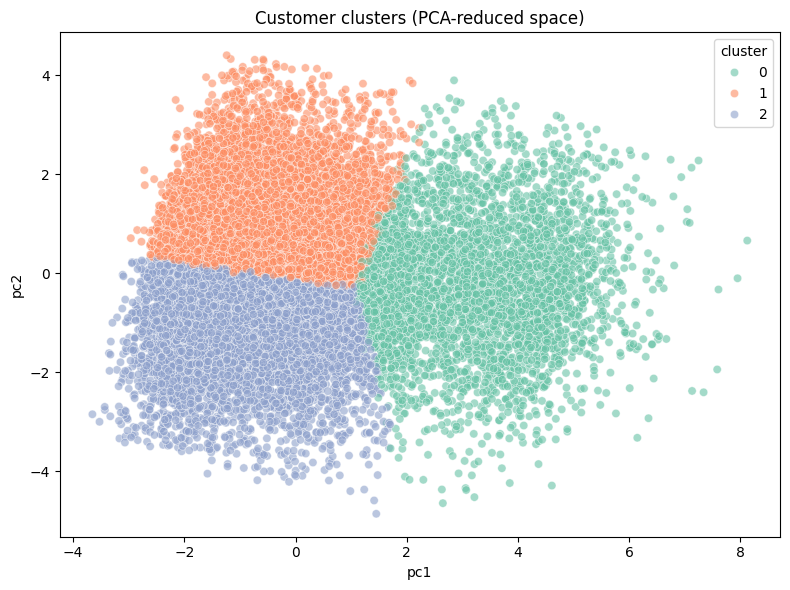

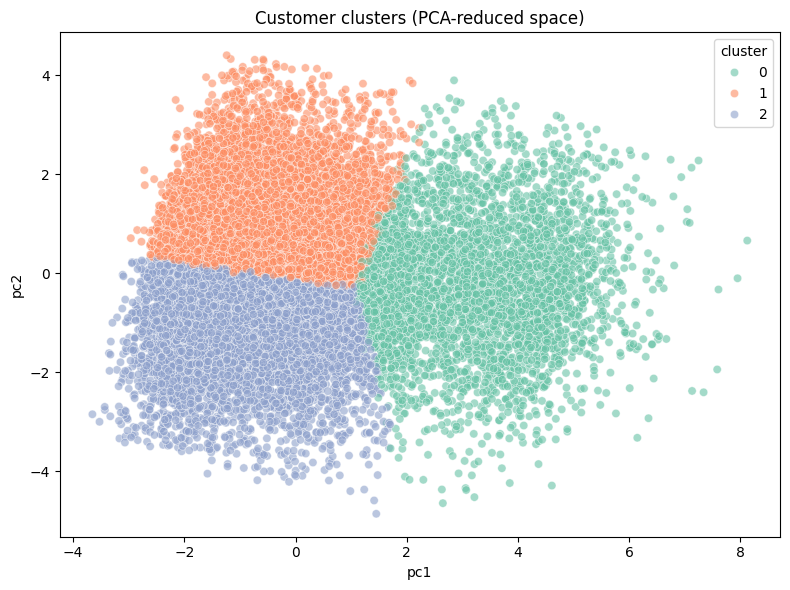

In [13]:

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(scaled_matrix)
cluster_df['pc1'] = components[:, 0]
cluster_df['pc2'] = components[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=cluster_df, x='pc1', y='pc2', hue='cluster', palette='Set2', alpha=0.6, ax=ax)
ax.set_title('Customer clusters (PCA-reduced space)')
plt.tight_layout()
fig



## 13. Radar chart comparison


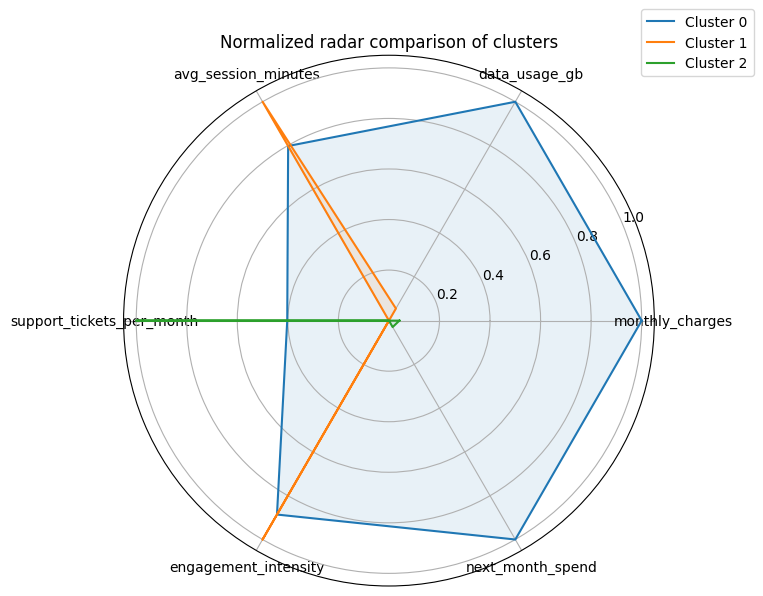

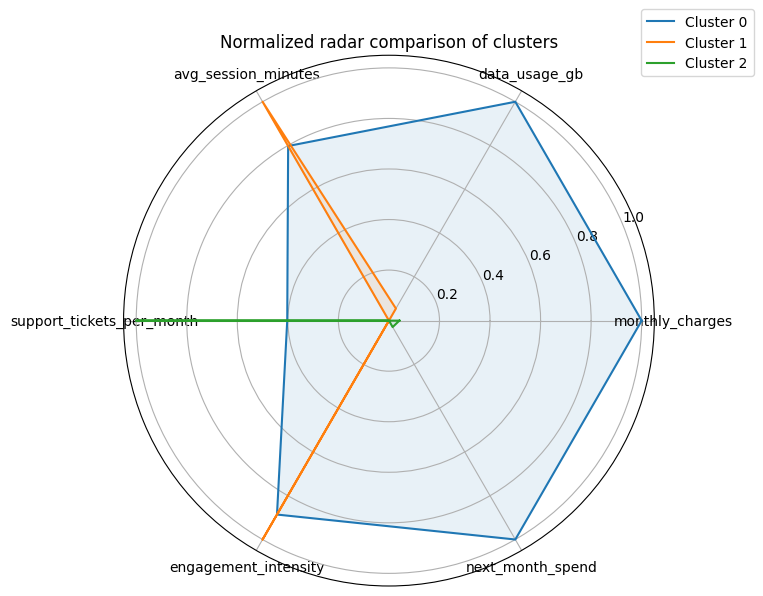

In [14]:

import numpy as np

radar_metrics = ['monthly_charges', 'data_usage_gb', 'avg_session_minutes', 'support_tickets_per_month', 'engagement_intensity', 'next_month_spend']
cluster_profile = cluster_df.groupby('cluster')[radar_metrics].mean()
normalized_profile = (cluster_profile - cluster_profile.min()) / (cluster_profile.max() - cluster_profile.min() + 1e-9)

angles = np.linspace(0, 2 * np.pi, len(radar_metrics), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)
for cluster_id, row in normalized_profile.iterrows():
    values = row.values
    values = np.concatenate([values, [values[0]]])
    ax.plot(angles, values, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_metrics)
ax.set_title('Normalized radar comparison of clusters')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
fig



## 14. Cluster profiling and export


In [15]:

cluster_summary = (
    cluster_df.groupby('cluster')[
        ['monthly_charges', 'data_usage_gb', 'avg_session_minutes', 'support_tickets_per_month', 'tenure_months', 'next_month_spend']
    ]
    .agg(['mean', 'median'])
)
cluster_summary


monthly_charges        data_usage_gb         avg_session_minutes  \
                   mean median          mean  median                mean   
cluster                                                                    
0              62.75584  65.23     13.006484  12.520           29.294578   
1              22.63140  18.62      9.002898   8.140           31.886563   
2              24.28928  20.30      8.768875   7.965           19.072057   

               support_tickets_per_month        tenure_months         \
        median                      mean median          mean median   
cluster                                                                
0        28.95                  0.147588  0.167     18.878036   19.0   
1        30.95                  0.136571  0.167     14.803267   14.0   
2        19.92                  0.163947  0.167     17.540981   17.0   

        next_month_spend         
                    mean median  
cluster                          
0              70.170714  73.77  
1              26.220410  24.62  
2              27.511946  25.98

In [16]:

segmented_export = cluster_df.copy()
segmented_export['retention_segment'] = driver_df['retention_segment']
segmented_export[['customer_id', 'cluster', 'retention_segment', 'churn_probability']].head()


,customer_id,cluster,retention_segment,churn_probability
0,1,1,Healthy Core,0.217271
1,2,2,App Adoption Opportunity,0.329611
2,3,2,Healthy Core,0.226212
3,4,1,Healthy Core,0.225605
4,5,2,Healthy Core,0.205985


In [17]:

SEGMENTED_PATH = PROJECT_ROOT / 'data' / 'processed' / 'segmented.csv'
SEGMENTED_PATH.parent.mkdir(parents=True, exist_ok=True)
segmented_export.to_csv(SEGMENTED_PATH, index=False)
SEGMENTED_PATH, len(segmented_export)


(WindowsPath('C:/Users/kkadema.SIRDC/Desktop/data analysis/data_science_project/data/processed/segmented.csv'),
 20000)


## 15. Cluster persona narrative

- **Cluster 0 ? Premium Data Power Users (19% of base):** Highest ARPU (\~) and next-month spend (\~), heavy data/app engagement, moderate churn probability (0.28). Protect value with loyalty perks and premium support.
- **Cluster 1 ? Low-Spend Stable Users (42%):** Lowest monthly charges (\~) and churn probability (0.24), modest support demand. Ideal control group; nurture toward cross-sell rather than defensive offers.
- **Cluster 2 ? Value Seekers (39%):** Similar spend to Cluster 1 but slightly higher churn (0.26) and ticket load. Target with app education plus bundle upgrades to lift ARPU while stabilizing experience.
